In [1]:
import sqlite3
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = sqlite3.connect('C:/Users/Andy/Documents/vscode/Vision_Tradingbot/andy/trading_data.db')

In [3]:
table_name = 'trading_data'
query = f"SELECT * FROM {table_name}"
df = pd.read_sql_query(query, conn)
df.replace('null', pd.NA, inplace = True)
df.dropna(inplace = True)
df

,id,image_data,tradable,trend,phase,after
0,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back
1,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend
2,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,breaks structure and reverses
3,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,continues trend
4,9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend
...,...,...,...,...,...,...
295,300,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,consolidates/no trend
297,302,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,breaks structure and reverses
298,303,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back
299,304,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend


In [4]:
def blob_to_image(blob):
    return np.array(Image.open(BytesIO(blob)))

df['images'] = df['image_data'].apply(blob_to_image)
df

,id,image_data,tradable,trend,phase,after,images
0,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,breaks structure and reverses,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,9,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...
295,300,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,consolidates/no trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
297,302,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,consolidation,breaks structure and reverses,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
298,303,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,up,pullback,continues pull back,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
299,304,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,yes,down,pullback,continues trend,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [5]:
images = np.array(df['images'])
trend = df[['trend']].values
phase = df[['phase']].values
after = df[['after']].values

In [6]:
images_float32 = [img.astype(np.float32) / 255.0 for img in images]
images_float32 = np.array(images_float32)

In [7]:
one_hot_encoder = OneHotEncoder()

trend_labels_encoded = one_hot_encoder.fit_transform(trend.reshape(-1, 1)).toarray()
phase_labels_encoded = one_hot_encoder.fit_transform(phase.reshape(-1, 1)).toarray()
after_labels_encoded = one_hot_encoder.fit_transform(after.reshape(-1, 1)).toarray()

In [8]:
trend_labels_encoded[0]

array([0., 0., 1.])

In [9]:
images_train, images_test, trend_train, trend_test, phase_train, phase_test, after_train, after_test = \
    train_test_split(images_float32, trend_labels_encoded, phase_labels_encoded, after_labels_encoded, test_size=0.2, random_state=42)

In [10]:
print(images_test)
print(after_test)
print(len(images_test))
print(len(after_test))

[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   ...
   [0.6862745  0.69803923 0.73333335]
   [0.6862745  0.69803923 0.73333335]
   [0.6862745  0.69803923 0.73333335]]

  [[0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   ...
   [0.72156864 0.73333335 0.76862746]
   [0.72156864 0.73333335 0.76862746]
   [0.72156864 0.73333335 0.76862746]]

  ...

  [[0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   [0.8784314  0.8901961  0.92156863]
   ...
   [0.9137255  0.9137255  0.9137255 ]
   [0.9137255  0.9137255  0.9137255 ]
   [0.9137255  0.9137255  0.9137255 ]]

  [[0.8784314  0.8901961  0.92156863]
   [0.8

In [11]:
input_layer = tf.keras.Input(shape=(721, 1030, 3))

# Convolutional layers
conv_layer1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)

pool_layer1 = tf.keras.layers.MaxPooling2D(2, 2)(conv_layer1)

flatten_layer = tf.keras.layers.Flatten()(pool_layer1)

# Output layer for category 1
trend_output = tf.keras.layers.Dense(3, activation='sigmoid', name='trend_output')(flatten_layer)

# Output layer for category 2
phase_output = tf.keras.layers.Dense(3, activation='sigmoid', name='phase_output')(flatten_layer)

# Output layer for category 3
after_output = tf.keras.layers.Dense(4, activation='sigmoid', name='after_output')(flatten_layer)

# Create model with input and multiple output layers
model = tf.keras.Model(inputs=input_layer, outputs=[trend_output, phase_output, after_output])

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss={'trend_output': 'categorical_crossentropy', 'phase_output': 'categorical_crossentropy', 'after_output': 'categorical_crossentropy'},
              metrics=['accuracy', 'accuracy', 'accuracy'])

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 721, 1030, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 719, 1028, │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 359, 514,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5904832)   │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trend_output        │ (None, 3)         │ 17,714,499 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ phase_output        │ (None, 3)         │ 17,714,499 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ after_output        │ (None, 4)         │ 23,619,332 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,049,226 (225.25 MB)

 Trainable params: 59,049,226 (225.25 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(x=images_train,
                    y={'trend_output': trend_train, 'phase_output': phase_train, 'after_output': after_train},
                    batch_size=32,
                    epochs=5)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - after_output_accuracy: 0.3054 - loss: 1221.3494 - phase_output_accuracy: 0.4313 - trend_output_accuracy: 0.4946
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - after_output_accuracy: 0.2827 - loss: 1012.6962 - phase_output_accuracy: 0.3633 - trend_output_accuracy: 0.4448
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - after_output_accuracy: 0.4878 - loss: 428.6623 - phase_output_accuracy: 0.4107 - trend_output_accuracy: 0.4407
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - after_output_accuracy: 0.4703 - loss: 125.0540 - phase_output_accuracy: 0.3736 - trend_output_accuracy: 0.4790
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - after_output_accuracy: 0.8238 - loss: 22.7028 - phase_output_accuracy: 0.5838 - trend_output_accuracy: 0.9074


In [15]:
evaluation_results = model.evaluate(images_test, {'trend_output': trend_test, 'phase_output': phase_test, 'after_output': after_test})
print("Evaluation results:", evaluation_results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step - after_output_accuracy: 0.2857 - loss: 49.9012 - phase_output_accuracy: 0.3408 - trend_output_accuracy: 0.2857
Evaluation results: [49.58579635620117, 0.3035714328289032, 0.3392857015132904, 0.3035714328289032]


In [16]:
predicted_outputs = model.predict(images_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 907ms/step


In [17]:
print(len(predicted_outputs))

3


In [18]:
predicted_outputs_trend, predicted_outputs_phase, predicted_outputs_after = predicted_outputs

In [19]:
predicted_classes_trend = np.argmax(predicted_outputs_trend, axis=1)
predicted_classes_phase = np.argmax(predicted_outputs_phase, axis=1)
predicted_classes_after = np.argmax(predicted_outputs_after, axis=1)

In [20]:
actual_classes_trend = np.argmax(trend_test, axis=1)
actual_classes_phase = np.argmax(phase_test, axis=1)
actual_classes_after = np.argmax(after_test, axis=1)

In [21]:
confusion_matrix_trend = confusion_matrix(actual_classes_trend, predicted_classes_trend)
confusion_matrix_phase = confusion_matrix(actual_classes_phase, predicted_classes_phase)
confusion_matrix_after = confusion_matrix(actual_classes_after, predicted_classes_after)

In [22]:
trend_labels = ['up', 'down', 'no trend']  # Replace with your actual labels
phase_labels = ['push', 'pull', 'consolidation']  # Replace with your actual labels
after_labels = ['continues trend', 'pull back', 'breaks structure and reverses', 'consolidates/no trend']  # Replace with your actual labels

In [23]:
predicted_labels_trend = [trend_labels[idx] for idx in predicted_classes_trend]
actual_labels_trend = [trend_labels[idx] for idx in actual_classes_trend]

predicted_labels_phase = [phase_labels[idx] for idx in predicted_classes_phase]
actual_labels_phase = [phase_labels[idx] for idx in actual_classes_phase]

predicted_labels_after = [after_labels[idx] for idx in predicted_classes_after]
actual_labels_after = [after_labels[idx] for idx in actual_classes_after]

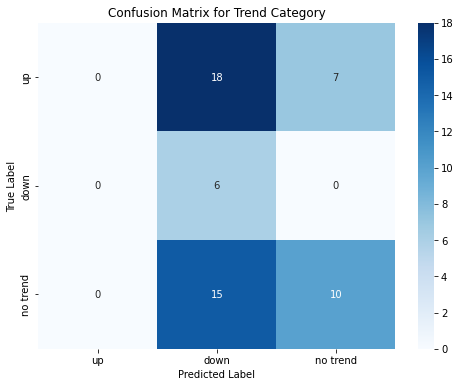

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_trend, annot=True, fmt='d', cmap='Blues', xticklabels=trend_labels, yticklabels=trend_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trend Category')
plt.show()

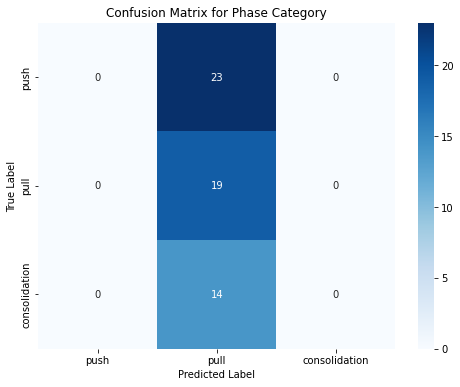

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_phase, annot=True, fmt='d', cmap='Blues', xticklabels=phase_labels, yticklabels=phase_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Phase Category')
plt.show()

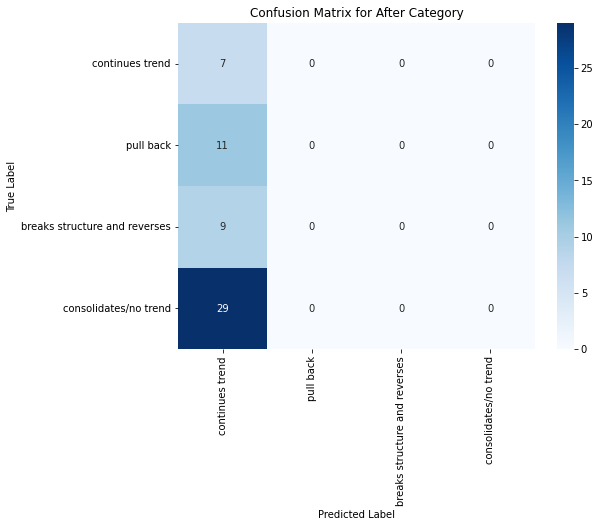

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_after, annot=True, fmt='d', cmap='Blues', xticklabels=after_labels, yticklabels=after_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for After Category')
plt.show()

In [27]:
classification_report_trend = classification_report(actual_classes_trend, predicted_classes_trend, zero_division=1)
classification_report_phase = classification_report(actual_classes_phase, predicted_classes_phase, zero_division=1)
classification_report_after = classification_report(actual_classes_after, predicted_classes_after, zero_division=1)

print("Classification Report for Trend:")
print(classification_report_trend)

print("Classification Report for Phase:")
print(classification_report_phase)

print("Classification Report for After:")
print(classification_report_after)

Classification Report for Trend:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        25
           1       0.15      1.00      0.27         6
           2       0.59      0.40      0.48        25

    accuracy                           0.29        56
   macro avg       0.58      0.47      0.25        56
weighted avg       0.73      0.29      0.24        56

Classification Report for Phase:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        23
           1       0.34      1.00      0.51        19
           2       1.00      0.00      0.00        14

    accuracy                           0.34        56
   macro avg       0.78      0.33      0.17        56
weighted avg       0.78      0.34      0.17        56

Classification Report for After:
              precision    recall  f1-score   support

           0       0.12      1.00      0.22         7
           1       1.00      0